In [1]:
import math
import pickle

import pandas as pd
import numpy as np
import os.path as op
import pylab as pl

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors

# Load data

In [2]:
major_class_df = pd.read_pickle('backups/major_class_df.pickle')
minor_class_df = pd.read_pickle('backups/minor_class_df.pickle')
novel_df = pd.read_pickle('backups/novel_df.pickle')

# major_class_df = major_class_df.drop(columns=['used_for_generation', 'molecular_fingerprint'])
# minor_class_df = minor_class_df.drop(columns=['used_for_generation', 'molecular_fingerprint'])
# novel_df = novel_df.drop(columns=['synthetic_accessibility_score', 'molecular_fingerprint'])

# major_class_df.columns = ['SMILES_major']
# minor_class_df.columns = ['SMILES_minor']
# novel_df.columns = ['SMILES_generated']

print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)
print(len(major_class_df))
print(len(minor_class_df))
print(len(novel_df))

Index(['SMILES_major', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
Index(['SMILES_minor', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
Index(['SMILES_generated', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
285408
189936
5836


In [3]:
smiles_df = pd.read_pickle('backups/smiles_corrected.pickle')

In [4]:
smiles_df['corrected_mol'] = smiles_df['corrected'].apply(Chem.MolFromSmiles)

In [5]:
print(len(smiles_df))
print(len(smiles_df.corrected_mol.isnull()))

12040
12040


In [14]:
print(smiles_df.columns)

Index(['with_errors', 'corrected', 'corrected_mol'], dtype='object')


In [16]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [17]:
smiles_df['corrected_mol'] = smiles_df['corrected'].apply(sanitize)

Sanitization error: Explicit valence for atom # 17 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 22 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 14 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 7 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 15 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 17 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 18 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 24 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 4 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 9 O, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 21 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 13 O, 3, is greater than permitted
Sanitiz

In [18]:
smiles_df = smiles_df.dropna()
print(len(smiles_df))

12040


In [19]:
smiles_df = smiles_df.drop(columns=['corrected_mol'])

In [20]:
print(smiles_df.columns)

Index(['with_errors', 'corrected'], dtype='object')


In [21]:
smiles_df.to_pickle('backups/smiles_corrected.pickle')

In [22]:
print(len(smiles_df))

12040


# Unique

In [24]:
corrected = smiles_df['corrected'].values.tolist()
generated = novel_df['SMILES_generated'].values.tolist()
minor = minor_class_df['SMILES_minor'].values.tolist()

duplicates = []
unique = []

for mol in corrected:
    if mol in minor or mol in generated:
        duplicates.append(mol)
    else:
        unique.append(mol)

In [27]:
print('unique corrected:', len(unique), 'or', len(unique) / len(corrected) * 100, '%')

unique corrected: 12028 or 99.90033222591363 %


# Scaffolds

In [28]:
unique_scaffolds_generated = set()
unique_scaffolds_minor = set()
unique_scaffolds_corrected = set()

In [29]:
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles

for index, row in smiles_df.iterrows():
    try:
        unique_scaffolds_corrected.add(MurckoScaffoldSmilesFromSmiles(row['corrected']))
    except Exception as e:
        print('smiles_df', e)

for index, row in minor_class_df.iterrows():
    try:
        unique_scaffolds_minor.add(MurckoScaffoldSmilesFromSmiles(row['SMILES_minor']))
    except Exception as e:
        print('minor_class_df', e)
        
for index, row in novel_df.iterrows():
    try:
        unique_scaffolds_generated.add(MurckoScaffoldSmilesFromSmiles(row['SMILES_generated']))
    except Exception as e:
        print('novel_df', e)

smiles_df Sanitization error: Explicit valence for atom # 8 N, 5, is greater than permitted
smiles_df Sanitization error: Explicit valence for atom # 12 N, 5, is greater than permitted
smiles_df Sanitization error: Explicit valence for atom # 18 N, 4, is greater than permitted


In [32]:
print('unique_scaffolds_generated', len(unique_scaffolds_generated))
print('unique_scaffolds_minor', len(unique_scaffolds_minor))
print('unique_scaffolds_corrected', len(unique_scaffolds_corrected))

unique_scaffolds_generated 3945
unique_scaffolds_minor 58229
unique_scaffolds_corrected 8426


In [31]:
print('novel_df', len(novel_df))
print('minor_class_df', len(minor_class_df))
print('smiles_df', len(smiles_df))

novel_df 5836
minor_class_df 189936
smiles_df 12040


In [33]:
generated_corrected_intersection = unique_scaffolds_generated.intersection(unique_scaffolds_corrected)
generated_minor_intersection = unique_scaffolds_generated.intersection(unique_scaffolds_minor)
minor_corrected_intersection = unique_scaffolds_minor.intersection(unique_scaffolds_corrected)

print('generated_corrected_intersection', len(generated_corrected_intersection))
print('generated_minor_intersection', len(generated_minor_intersection))
print('minor_corrected_intersection', len(minor_corrected_intersection))

generated_corrected_intersection 742
generated_minor_intersection 2558
minor_corrected_intersection 2594


In [35]:
print(len(generated_corrected_intersection) / len(unique_scaffolds_corrected) * 100, '%')
print(len(generated_corrected_intersection) / len(unique_scaffolds_generated) * 100, '%')
print(len(generated_minor_intersection) / len(unique_scaffolds_generated) * 100, '%')
print(len(minor_corrected_intersection) / len(unique_scaffolds_corrected) * 100, '%')

8.806076430097317 %
18.808618504435994 %
64.84157160963244 %
30.78566342273914 %


# Fingerprint similarity analysis

In [46]:
print('corrected', smiles_df.columns)
print('generated', novel_df.columns)
print('undersampled', minor_class_df.columns)

print('corrected len', len(smiles_df))
print('generated len', len(novel_df))
print('undersampled len', len(minor_class_df))

corrected Index(['with_errors', 'corrected', 'key'], dtype='object')
generated Index(['SMILES_generated', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA', 'key'],
      dtype='object')
undersampled Index(['SMILES_minor', 'mol', 'synthetic_accessibility_score',
       'molecular_weight', 'logP', 'TPSA'],
      dtype='object')
corrected len 12040
generated len 5836
undersampled len 189936


In [38]:
%%time

from pandas import DataFrame, merge

# add fake column to merge on
smiles_df['key'] = 0
novel_df['key'] = 0

generated_vs_corrected_cartesian_df = merge(novel_df, smiles_df, on='key')[['SMILES_generated', 'corrected']]

CPU times: user 17.3 s, sys: 7.88 s, total: 25.2 s
Wall time: 23.9 s


In [40]:
print(generated_vs_corrected_cartesian_df.columns)
print(len(generated_vs_corrected_cartesian_df))

Index(['SMILES_generated', 'corrected'], dtype='object')
70265440


drop duplicates

In [41]:
generated_vs_corrected_cartesian_df = generated_vs_corrected_cartesian_df.drop_duplicates(subset=['SMILES_generated', 'corrected'], keep=False)

In [42]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

def get_tanimoto_similarity_from_smiles(a_row):
    smiles_string_a = a_row[0]
    smiles_string_b = a_row[1]
    mol_a = Chem.MolFromSmiles(smiles_string_a)
    mol_b = Chem.MolFromSmiles(smiles_string_b)
    
    if mol_a and mol_b:
        morgan_fp_a = AllChem.GetMorganFingerprintAsBitVect(mol_a, 2)  # radius = 2
        morgan_fp_b = AllChem.GetMorganFingerprintAsBitVect(mol_b, 2)  # radius = 2
        
        return DataStructs.TanimotoSimilarity(morgan_fp_a, morgan_fp_b)

In [43]:
print(len(generated_vs_corrected_cartesian_df))

64331311


In [44]:
# compute on a whole dataset
generated_vs_corrected_cartesian_df['tanimoto_similarity'] = generated_vs_corrected_cartesian_df.apply(get_tanimoto_similarity_from_smiles, axis=1)

In [45]:
generated_vs_corrected_cartesian_df.to_pickle('backups/generated_vs_corrected_cartesian_tanimoto_df.pickle')

In [50]:
%%time

from pandas import DataFrame, merge

# add fake column to merge on
smiles_df['key'] = 0
minor_class_df['key'] = 0

#drop random 90% of rows
remove_n_a = int(0.9 * len(smiles_df))
remove_n_b = int(0.9 * len(minor_class_df))
drop_indices_a = np.random.choice(smiles_df.index, remove_n_a, replace=False)
drop_indices_b = np.random.choice(minor_class_df.index, remove_n_b, replace=False)
smiles_df_drop = smiles_df.drop(drop_indices_a)
minor_class_df_drop = minor_class_df.drop(drop_indices_b)

corrected_vs_minor_cartesian_df = merge(smiles_df_drop, minor_class_df_drop, on='key')[['corrected', 'SMILES_minor']]

CPU times: user 8.18 s, sys: 2.82 s, total: 11 s
Wall time: 9.87 s


In [51]:
print(len(corrected_vs_minor_cartesian_df))

22868776


In [52]:
# drop duplicates
corrected_vs_minor_cartesian_df = corrected_vs_minor_cartesian_df.drop_duplicates(subset=['corrected', 'SMILES_minor'], keep=False)

In [53]:
print(len(corrected_vs_minor_cartesian_df))

22868776


In [54]:
# compute on a sample subset
corrected_vs_minor_cartesian_df['tanimoto_similarity'] = corrected_vs_minor_cartesian_df.apply(get_tanimoto_similarity_from_smiles, axis=1)

In [55]:
corrected_vs_minor_cartesian_df.to_pickle('backups/corrected_vs_minor_cartesian_tanimoto_df.pickle')

# Plot

In [56]:
corrected_vs_minor_df = pd.read_pickle('backups/corrected_vs_minor_cartesian_tanimoto_df.pickle')
generated_vs_corrected_df = pd.read_pickle('backups/generated_vs_corrected_cartesian_tanimoto_df.pickle')
generated_vs_minor_df = pd.read_pickle('backups/df_subset.pickle')

print(len(corrected_vs_minor_df))
print(len(generated_vs_corrected_df))
print(len(generated_vs_minor_df))

print(corrected_vs_minor_df.columns)
print(generated_vs_corrected_df.columns)
print(generated_vs_minor_df.columns)

22868776
64331311
102584434
Index(['corrected', 'SMILES_minor', 'tanimoto_similarity'], dtype='object')
Index(['SMILES_generated', 'corrected', 'tanimoto_similarity'], dtype='object')
Index(['SMILES_generated', 'SMILES_minor', 'tanimoto_similarity'], dtype='object')


(0, 0.3)

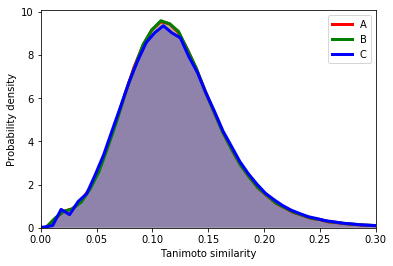

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, ax = plt.figure(figsize=(8,6))

# generated_vs_corrected
sns.distplot(generated_vs_corrected_df.tanimoto_similarity, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, color='red', label="A")
# generated_vs_undersampled
sns.distplot(generated_vs_minor_df.tanimoto_similarity, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="B", color='green')
# corrected_vs_undersampled
sns.distplot(corrected_vs_minor_df.tanimoto_similarity, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label="C", color='blue')
plt.xlabel('Tanimoto similarity')
plt.ylabel('Probability density')
plt.legend(loc='upper right')
plt.xlim(0, 0.3)

In [64]:
print('mean', generated_vs_corrected_df.tanimoto_similarity.mean())
print('median', generated_vs_corrected_df.tanimoto_similarity.median())
print('max', generated_vs_corrected_df.tanimoto_similarity.max())

mean 0.12022715753543342
median 0.11578947368421053
max 1.0


In [65]:
print('mean', generated_vs_minor_df.tanimoto_similarity.mean())
print('median', generated_vs_minor_df.tanimoto_similarity.median())
print('max', generated_vs_minor_df.tanimoto_similarity.max())

mean 0.12074941866642362
median 0.11594202898550725
max 1.0


In [66]:
print('mean', corrected_vs_minor_df.tanimoto_similarity.mean())
print('median', corrected_vs_minor_df.tanimoto_similarity.median())
print('max', corrected_vs_minor_df.tanimoto_similarity.max())

mean 0.12091373889595697
median 0.11627906976744186
max 0.96
